# Technical Analysis Challenge
CodeIT Suisse 2019

## Problem Statement

Use the first few *known* values of *stock price* as **training data** to recommend buy and sell trades for the next few *unknown* values of **test data**.

The price is modeled by the following function family:

\begin{equation}
price_i(t_i) = base + trend * t_i + \sum_{w=1}^{sine\_count} scale_w * \sin(2\pi * period\_count_w * t_i)
\end{equation}

**Training data** values are *truncated* to integers. **Test data** is precise.

### Picture Worth a Thousand Words
Illustrative example of sine_count=1 with 30 values of training data and 60 values of test data

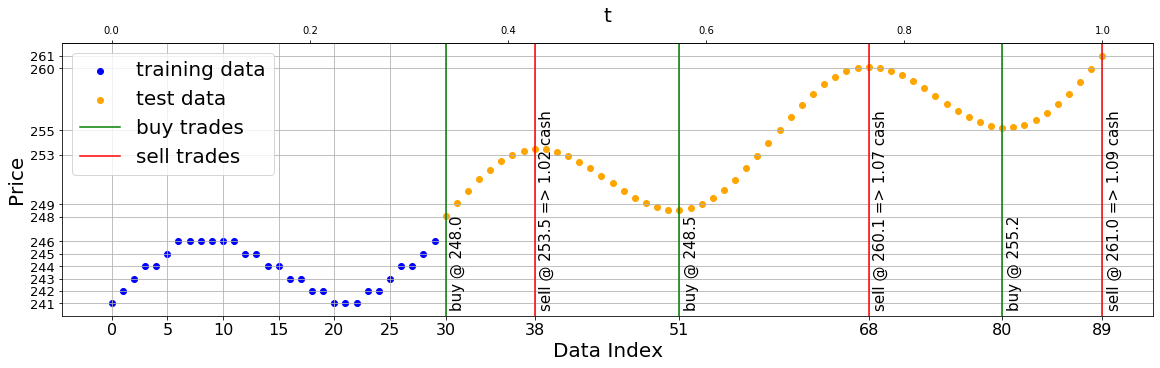

Training data - your input (blue line):
[241, 242, 243, 244, 244, 245, 246, 246, 246, 246, 246, 246, 245, 245, 244, 244, 243, 243, 242, 242, 241, 241,
 241, 242, 242, 243, 244, 244, 245, 246]

Test data - you won't see it (orange line):
[248.0237288698771, 249.08090060113744, 250.08826187106925, 251.01083737788557, 251.8174407897403,
 252.4820684229782, 252.98506131430463, 253.31398375532103, 253.46417902881325, 253.43897751163246,
 253.24954784430986, 252.91439781844994, 252.4585472866212, 251.91241005636977, 251.3104347351166,
 250.6895652648834, 250.08758994363023, 249.5414527133788, 249.0856021815501, 248.75045215569014,
 248.56102248836754, 248.53582097118675, 248.68601624467897, 249.01493868569537, 249.5179315770218,
 250.1825592102597, 250.98916262211443, 251.91173812893075, 252.91909939886256, 253.97627113012288,
 255.0460520535713, 256.0906774110047, 257.0735066150713, 257.96066067139145, 258.72253618853586,
 259.3351283166435, 259.7811034942037, 260.050574063288, 260.14154013

In [1]:
%matplotlib inline

import importlib
import matplotlib.pyplot as plt
import numpy as np
from app import generation, trade_optimizer
import pprint

importlib.reload(generation)

def show_sample():
    builder = generation.ScenarioBuilder(1, train_size=30, test_size=60)
    builder.set_base().set_trend((20, 20)).add_waves(1, period_count_range=(3, 3), scale_range=(4, 4))
    scenario = builder.build()
    size = scenario.train_size + scenario.test_size
    optimal_trades = [t + scenario.train_size for t in trade_optimizer.get_optimal_trades(scenario.test_signal)]

    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(16, 5)
    plt.grid(True)
    training_line = ax.scatter(np.arange(scenario.train_size), scenario.train_signal, color='blue', label='training data')
    test_line = ax.scatter(scenario.train_size + np.arange(scenario.test_size), scenario.test_signal, color='orange', label='test data')
    plt.xticks(list(range(0, optimal_trades[0], 5)) + optimal_trades, fontsize=16)
    prices = [scenario.test_signal[t - scenario.train_size] for t in optimal_trades]
    yticks = (list(range(scenario.train_signal.min(), scenario.train_signal.max() + 1))
               + np.unique(np.round(prices)).tolist())
    plt.yticks(yticks, fontsize=13)
    plt.xlabel('Data Index', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    
    ax2 = ax.secondary_xaxis('top', functions=(lambda x: x/(size - 1), lambda t: t*(size - 1)))
    ax2.set_xlabel('t', fontsize=20, )

    min_y = min(scenario.train_signal.min(), scenario.test_signal.min())
    money = 1
    for i, x in enumerate(optimal_trades):
        price = scenario.test_signal[x - scenario.train_size]
        isSell = i % 2
        if isSell:
            sell_line = plt.axvline(x, 0, price, color='red', label='sell trades')
            money = price * security
            text = f"sell @ {price:.1f} => {money:,.2f} cash"
        else:
            buy_line = plt.axvline(x, 0, price, color='green', label='buy trades')
            security = money / price
            text = f"buy @ {price:.1f}"
            
        plt.text(x+0.4, min_y-0.3, text, rotation=90, fontsize=15)
        
    ax.legend(handles=(training_line, test_line, buy_line, sell_line), loc='upper left', fontsize=20)
    plt.show()
    print("Training data - your input (blue line):")
    pprint.pprint(scenario.train_signal.tolist(), compact=True, width=110)
    print()
    print("Test data - you won't see it (orange line):")
    pprint.pprint(scenario.test_signal.tolist(), compact=True, width=110)
    print()
    print("Optimal trades - the output you need to produce (alternating green and red lines):")
    pprint.pprint(optimal_trades, compact=True)    
    print()
    print(f"Max final amount of cash is {money:.2f}")
    print()
    m = scenario.model_parameters
    print("This example uses the following function family parameters:")
    print(f"Base={m[0]:.3g}, trend={m[1]:.3g}, scale={m[2]:.3g}, period_count={m[3]:.3g}, sine_count={scenario.sine_count}")

show_sample()

### Rules and Assumptions

**Training data** is immediately followed by **test data** with their values **price[i]** indexed as

\begin{align*}
&i \in [0,{training\_size + test\_size - 1}] \\
and \\
&t_i = \dfrac{i}{training\_size + test\_size - 1} \in [0,1]
\end{align*}

Price model parameter boundaries:
\begin{align*}
&base \in [200, 300) \\
&trend \in [-100, 100) \\
&scale_i \in [5, 15) \\
&period\_count_i \in [10, 100) \\
&price_i > 0
\end{align*}

Initial amount of cash is 1.

First trade is a "buy". Trade sequence consists of alternating "buy" and "sell" trades.

If the last recommended trade is a "buy" (i.e. recommendation contains odd number of indexes), then a "sell" will be implied at the last index.

Every trade is full, i.e.:
- "buy" converts all cash to stock
- "sell" converts all stock back to cash

Solution timeout is 28 seconds.

### Input
Expose endpoint `/technical-analysis` accepting POST requests.

You will receive **training data** for 4 scenarios in separate arrays, each containing 100 values.
See [Scoring](#scoring) section below with explanation of scenarios.

### Output
You need to produce trade recommendations sequences for all 4 input scenarios. Each recommendation sequence will be applied to corresponding **test data** to calculate the final cash amount. Every **test data** sequence contains 1,000 values indexed [100, 1099]. So every trade recommendation sequence should be monotonically increasing within [100, 1099] and is assumed to contain alternating buy-sell indexes.

#### Sample Input
Each input contains training data for 4 scenarios, for example:

In [2]:
import pprint
import matplotlib.pyplot as plt
import numpy as np
from app import generation, trade_optimizer, evaluate

scenarios = generation.get_standard_scenarios(1)
pprint.pprint(evaluate.create_challenge_input(scenarios), width=106, compact=True)

[[283, 285, 287, 288, 290, 291, 291, 291, 290, 289, 287, 285, 283, 280, 278, 276, 275, 273, 273, 273, 273,
  274, 276, 277, 279, 282, 284, 286, 287, 289, 289, 290, 289, 288, 287, 285, 283, 281, 279, 276, 275, 273,
  272, 271, 271, 272, 273, 275, 277, 279, 281, 283, 285, 286, 288, 288, 288, 288, 287, 285, 283, 281, 279,
  277, 275, 273, 271, 270, 270, 270, 271, 272, 274, 276, 278, 280, 282, 284, 285, 286, 287, 287, 286, 285,
  284, 282, 279, 277, 275, 273, 271, 270, 269, 269, 269, 270, 271, 273, 275, 277],
 [268, 273, 277, 280, 281, 280, 277, 273, 268, 264, 261, 259, 259, 261, 263, 266, 269, 271, 271, 270, 268,
  265, 262, 260, 259, 259, 261, 265, 269, 274, 278, 280, 280, 278, 275, 270, 264, 259, 255, 253, 253, 255,
  258, 262, 267, 271, 273, 274, 274, 272, 269, 266, 263, 262, 262, 264, 266, 269, 272, 274, 274, 273, 270,
  266, 261, 257, 253, 252, 252, 255, 259, 264, 270, 274, 278, 279, 278, 276, 272, 267, 263, 259, 257, 257,
  258, 261, 263, 266, 268, 269, 268, 266, 263, 260, 258, 257,

#### Sample Output

In [3]:
optimal_trades = [list(s.train_size + t for t in trade_optimizer.get_optimal_trades(s.test_signal)) for s in scenarios]
pprint.pprint(optimal_trades, width=120, compact=True)

[[100, 105, 118, 130, 143, 155, 167, 180, 192, 204, 217, 229, 242, 254, 266, 279, 291, 303, 316, 328, 341, 353, 366,
  378, 390, 403, 415, 427, 440, 452, 465, 477, 489, 502, 514, 526, 539, 551, 564, 576, 589, 601, 613, 625, 638, 650,
  663, 675, 688, 700, 712, 725, 737, 749, 762, 774, 787, 799, 811, 824, 836, 848, 861, 873, 886, 898, 911, 923, 935,
  948, 960, 972, 985, 997, 1010, 1022, 1034, 1047, 1059, 1071, 1084, 1096],
 [100, 103, 111, 118, 125, 131, 138, 146, 154, 160, 167, 174, 182, 189, 196, 202, 210, 218, 225, 231, 238, 245, 253,
  261, 267, 273, 281, 289, 296, 303, 309, 316, 324, 332, 338, 345, 352, 360, 367, 374, 380, 388, 396, 403, 409, 416,
  423, 431, 439, 445, 451, 459, 467, 474, 481, 487, 494, 502, 510, 516, 523, 530, 538, 545, 552, 558, 566, 574, 581,
  587, 594, 601, 609, 617, 623, 629, 637, 645, 652, 659, 665, 672, 680, 688, 694, 700, 708, 716, 723, 730, 736, 744,
  752, 759, 765, 772, 779, 787, 795, 801, 807, 815, 823, 830, 837, 843, 850, 858, 866, 872, 879, 886, 894

<a id='scoring'></a>
### Scoring
Input data contains 4 scenarios in this order:

| Scenario | sine_count | weight |
|-|-|-|
| 1 | 1 | 0.1 |
| 2 | 2 | 0.2 |
| 3 | 3 | 0.3 |
| 4 | 4 | 0.4 |

Assuming the initial amount of cash is 1, scenario score is:

\begin{equation}
score_s = \max(0, \dfrac{final\_cash_s - 1}{max\_final\_cash_s - 1})
\end{equation}

Where

* **final_cash** - final amount of cash after trading on your recommendations
* **max_final_cash** - final amount of cash after trading on optimal strategy a.k.a. "buy low, sell high"

Total score is:

\begin{equation}
total\_coorinator\_score = \lceil{100 * \sum_{s=1}^{scenario\_count} weight_s * score_s}\rceil
\end{equation}

### Some Inspirational Visualization
**<font color='blue'>Blue</font>** - training data<br/>
**<font color='orange'>Orange</font>** - test data

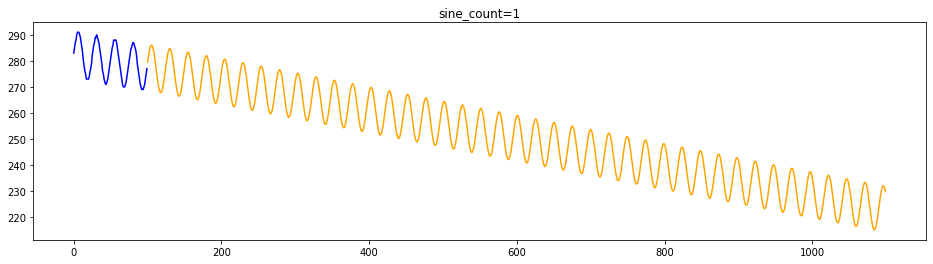

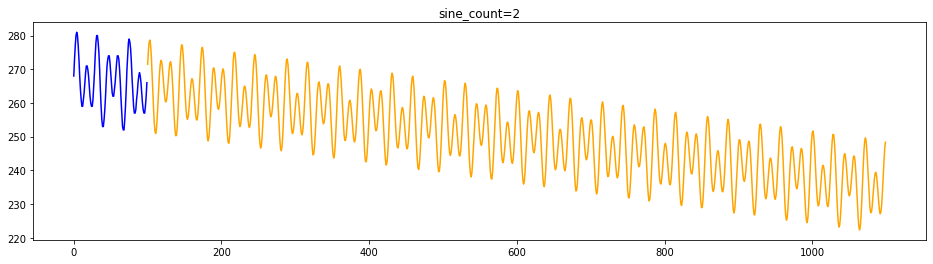

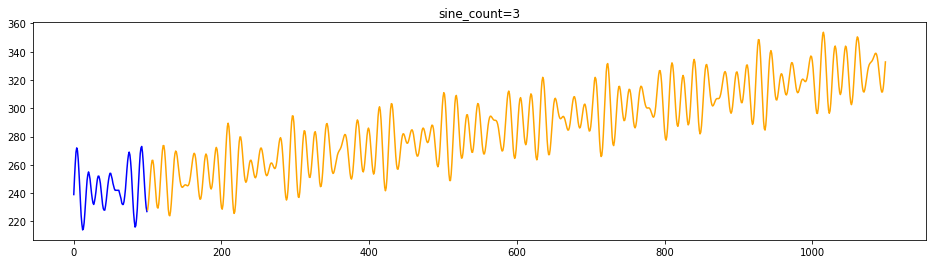

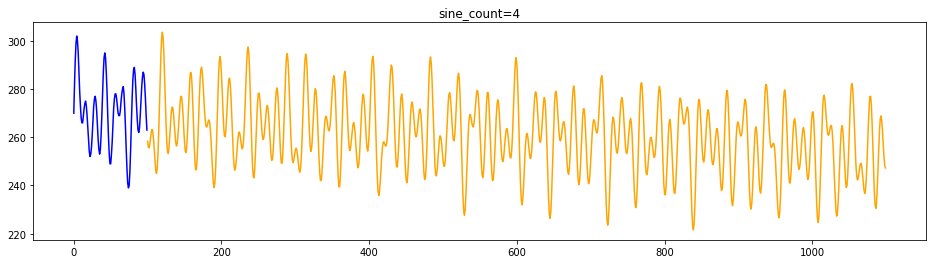

In [4]:
for scenario, optimals in zip(scenarios, optimal_trades):
    fig = plt.figure()
    fig.set_size_inches(16, 4)
    plt.title(f"sine_count={scenario.sine_count}")
    plt.plot(np.arange(scenario.train_size), scenario.train_signal, color='blue')
    plt.plot(scenario.train_size + np.arange(scenario.test_size), scenario.test_signal, color='orange')

Since you've scrolled this far, here's a Python code snippet to generate more training data:

```python
import numpy as np
import matplotlib.pyplot as plt

def generate_price(random_seed, sine_count):
    rnd = np.random.RandomState(random_seed)
    train_size = 100
    test_size = 1_000
    size = train_size + test_size
    t = np.linspace(0, 1, num=size)

    base = rnd.uniform(200, 300)    
    trend = rnd.uniform(-100, 100)
    price = np.full(size, base) + trend * t
    for _ in range(sine_count):
        scale = rnd.uniform(5, 15)
        period_count = rnd.uniform(10, 100)
        price += scale * np.sin(2 * np.pi * period_count * t)

    return price[:train_size].astype(np.int), price[-test_size:]

# And here's how to generate and visualize the data
train, test = generate_price(random_seed=1, sine_count=2)
fig = plt.figure()
fig.set_size_inches(16, 4)
plt.plot(np.arange(train.shape[0]), train)
plt.plot(train.shape[0] + np.arange(test.shape[0]), test)
plt.show()
```